In [186]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt

RATIO = 125.0/116.0
DATES = ['12.04.2024', '16.04.2024', '17.04.2024', '18.04.2024', '23.04.2024', 
         '25.04.2024', '30.04.2024', '09.05.2024', '15.08.2024', '28.08.2024',
         '11.10.2024', '14.10.2024', '09.12.2024', '10.12.2024']
ds = {}

#Load data
raw_dataset= pd.read_csv('YuriData.TXT', na_values='NaN', 
                         names=['WeekDay', 'Date', 'Hour', 
                         'T1', 'T2', 'T3', 'P','I'])
raw_dataset= pd.DataFrame({'T': raw_dataset.pop('T3'), 
                            'I': raw_dataset.pop('I'), 
                            'Date': raw_dataset.pop('Date')})
raw_dataset = raw_dataset.dropna()
for m in DATES:
    ds1= raw_dataset.copy()
    ds1= ds1.drop(ds1[ds1['Date'] != m].index)
    ds1['Ti']= ds1['T'].shift(1)
    ds2= raw_dataset.copy()
    ds2= ds2.drop(ds2[ds2['Date'] != m].index)
    ds2['Ti']= ds2['T'].shift(-1)
    ds[m]= pd.concat([ds1, ds2])
ds_t= pd.concat(ds)
ds_t.pop('Date')
ds_t= ds_t.dropna()
#ds_t= ds_t.drop(ds_t[ds_t['I'] < 500].index)
ds_t['Ti']= ds_t['Ti'] * RATIO
ds_t['T']= ds_t['T'] * RATIO
#ds_t['Warm'] = (ds_t['Ti'] < ds_t['T'])*1.0
#ds_t['Cold'] = (ds_t['Ti'] > ds_t['T'])*1.0
#ds_t = ds_t.drop(ds_t[ds_t['Cold'] == ds_t['Warm']].index)
#The time is not relevant here because the interval is constant (about 1 minute)
print(ds_t.describe())


                 T            I           Ti
count  1902.000000  1902.000000  1902.000000
mean     41.580437   806.499474    41.580437
std      25.406248   337.037733    25.406248
min      18.318966    19.000000    18.318966
25%      29.633621   668.250000    29.633621
50%      32.543103   971.000000    32.543103
75%      38.254310  1033.000000    38.254310
max     125.000000  1508.000000   125.000000


In [187]:
#Split tran and test sets
train= ds_t.sample(frac=0.8, random_state=0)
test= ds_t.drop(train.index)

#Get data stats
train_stats = train.describe()
train_stats.pop('T')
train_stats = train_stats.transpose()
print(train_stats)

     count        mean         std        min         25%         50%  \
I   1522.0  810.124836  337.399184  19.000000  695.000000  975.000000   
Ti  1522.0   41.777564   25.685219  18.318966   29.633621   32.704741   

           75%     max  
I   1037.75000  1508.0  
Ti    38.25431   125.0  


In [188]:
#Constants from the dataset to normalize
MEAN_TEMP= 41.777564
MEAN_IRD= 810.124836
STD_TEMP= 25.685219
STD_IRD= 337.399184

#Pop the output from the dataset
train_labels = train.pop('T')
test_labels = test.pop('T')

#Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

#Build model
def build_model():
  model = keras.Sequential([
    layers.Dense(250, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(250, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  
  return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Run the model
EPOCHS = 1000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

c:\Users\Josè Castillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
31,1.810355,0.920598,1.810355,7.778341,2.594882,7.778341,31
32,1.825747,0.972697,1.825747,5.511818,1.632941,5.511818,32
33,1.631090,0.922756,1.631090,3.108402,1.464916,3.108402,33
34,1.612162,0.920660,1.612162,3.331418,1.594445,3.331418,34
35,1.731583,0.959434,1.731583,2.231132,1.253911,2.231132,35


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


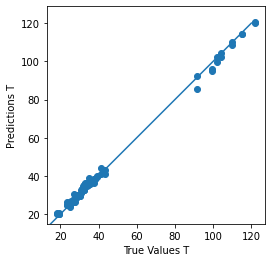

In [189]:
#Test the model
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values T')
plt.ylabel('Predictions T')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-120, 120], [-120, 120])

In [190]:
model.save('YuriModel.keras')

In [191]:
print(normed_test_data)

                       I        Ti
12.04.2024 12  -2.187690 -0.841990
           12  -2.187690 -0.841990
16.04.2024 19  -2.279569 -0.577683
           22  -2.285497 -0.674176
           43  -0.379743 -0.074240
...                  ...       ...
10.12.2024 835  0.743556  3.105839
           859  0.782086  2.631764
           879 -1.511933  2.170275
           882 -1.538607  1.805279
           902 -1.929835  0.018058

[84 rows x 2 columns]


In [192]:
print(test)

                   I          Ti
12.04.2024 12     72   20.150862
           12     72   20.150862
16.04.2024 19     41   26.939655
           22     39   24.461207
           43    682   39.870690
...              ...         ...
10.12.2024 835  1061  121.551724
           859  1074  109.375000
           879   300   97.521552
           882   291   88.146552
           902   159   42.241379

[84 rows x 2 columns]


In [ ]:

yuriModel= tf.keras.models.load_model('YuriModel.keras')
state=1

def step(t: float):
    t_norm = (t - MEAN_TEMP) / STD_TEMP
    if(state == 0):
        ird_norm= (1361 - MEAN_IRD) / STD_IRD
    else:
        ird_norm= (400- MEAN_IRD) / STD_IRD
    return yuriModel.predict(tf.constant([[ird_norm, t_norm]]), verbose=0).flatten()[0]

print(step(121))

118.28852
